<a href="https://colab.research.google.com/github/Yukti-K/MIE624_RL/blob/main/A5_QL_inventory_yukti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RL optimal policy: [[14.]
 [20.]
 [15.]
 [22.]
 [19.]
 [20.]
 [19.]
 [13.]
 [ 7.]
 [ 6.]
 [10.]
 [11.]
 [11.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 0.]]
RL optimal policy: [[14.]
 [20.]
 [15.]
 [17.]
 [21.]
 [10.]
 [14.]
 [ 8.]
 [ 6.]
 [ 9.]
 [15.]
 [ 3.]
 [ 3.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 8.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 0.]]
RL optimal policy: [[14.]
 [20.]
 [15.]
 [10.]
 [13.]
 [12.]
 [16.]
 [13.]
 [ 7.]
 [13.]
 [ 9.]
 [ 6.]
 [13.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 0.]]
RL optimal policy: [[19.]
 [20.]
 [18.]
 [12.]
 [17.]
 [17.]
 [17.]
 [13.]
 [14.]
 [15.]
 [ 8.]
 [10.]
 [13.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 0.]]
RL optimal policy: [[20.]
 [13.]
 [16.]
 [19.]
 [10.]
 [ 8.]
 [11.]
 [13.]
 [ 4.]
 [10.]
 [ 9.]
 [ 9.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 9.]
 [ 0.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 0.

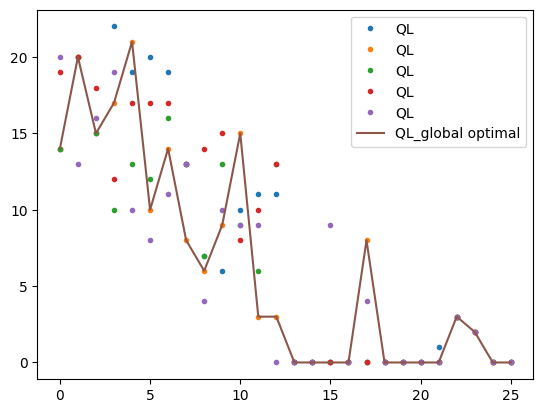

In [2]:
import gym
import numpy as np
import collections
#from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
#from A4_DP_value_ite_inventory_R1 import transition_probability
##from A4_DP_value_ite_inventory_R1 import value_iteration
#from A4_DP_value_ite_inventory_R1 import calc_limiting_dist
#from A4_DP_value_ite_inventory_R1 import calc_profit

# Constants
ENV_NAME = "InventoryManagement"
GAMMA = 0.9 #discount_factor
ALPHA = 0.1
MAX_ITERATIONS = 20000


C_f = 300
C_v = 100
C_b = 50
C_c = 30
rev = 400 #revenue

lambda_val = 7
K = 20 #maximum inventory carrying capacity
B=5 #backorder limit

mu= lambda_val
episode_length =100

class InventoryEnvironment(gym.Env):
    def __init__(self):
        #self.action_space = gym.spaces.Discrete(K+B+1)  # Action space for order quantities (0 to 50)
        #self.observation_space = gym.spaces.Box(low=-B, high=K, shape=(K+B+1, 0), dtype=np.integer)  # State space for inventory levels (0 to 50)
        #self.observation_space = gym.spaces.flatten_space(self.observation_space)
        self.inventory_space = np.array([(i) for i in range(-B, K + 1)])
        self.actions = np.array(range(K + B + 1))
        self.num_states=self.inventory_space.shape[0]
        self.num_actions=self.actions.shape[0]
        self.inventory = 0  # Initial inventory level (initial state)
        self.steps=0

    def step(self, action):
        action = min(action, K - self.inventory)

        # Simulate demand using Poisson distribution
        demand = np.random.poisson(lambda_val)

        # Update inventory
        next_inventory = self.inventory + action - demand

        # Apply backorder limit constraints
        if next_inventory < -B:
            lost_sales = -B - next_inventory  # Excess demand that cannot be backordered
            next_inventory = -B  # Backorders capped
        else:
            lost_sales = 0

        # Compute reward based on costs
        order_cost = C_f + action * C_v if action > 0 else 0  # Ordering cost
        carrying_cost = max(0, next_inventory) * C_c  # Carrying cost
        backorder_cost = max(0, -next_inventory) * C_b  # Backorder cost
        revenue = min(demand, self.inventory + action) * rev  # Revenue

        reward = revenue - (order_cost + carrying_cost + backorder_cost)  # Net reward

        # Determine next state index
        next_state = self.inventory_space.tolist().index(next_inventory)

        self.inventory = next_inventory
        self.steps += 1

        done = self.steps == episode_length  # Check if episode is over
        return next_state, next_inventory, reward, done


    def reset(self):

        self.inventory = np.random.randint(0, K + 1)  # Start with a random inventory level
        self.steps = 0
        state = self.inventory_space.tolist().index(next_inventory)
        return state, self.inventory

class QLearningAgent:
    def __init__(self, n_actions, n_states):
        self.n_actions = n_actions
        self.n_states = n_states
        self.q_table = np.zeros((n_states, n_actions))
        self.q_table_visits = np.zeros((n_states, n_actions))

    def choose_action(self, state, inventory, epsilon):
        if np.random.random() < epsilon:
            #action = np.random.choice(self.n_actions)
            action =  min (np.random.choice(self.n_actions), K - inventory)  # Explore#A constraint so actions that are not feasible are never attempted
        else:
            action = np.argmax(self.q_table[state, :])  # Exploit
        self.q_table_visits[state,action]+=1
        return action

    def update_q_table(self, state, action, reward, next_state):

        best_next_action = np.argmax(self.q_table[next_state, :])
        self.q_table[state, action] += ALPHA * (reward + GAMMA * self.q_table[next_state, best_next_action] - self.q_table[state, action])

    def optimal_action(self):
        policy= np.zeros((self.n_states,1))
        for i in range(self.n_states):
            policy[i] = np.argmax(self.q_table[i, :])
            #writer.add_scalar("policy", policy[i], i)
        return policy
    def get_q_table(self):
        return (self.q_table)

if __name__ == "__main__":#this will be called if running this as main script; if instead this module is called from a differnt script this part will not be run
    env = InventoryEnvironment()
    #agent = QLearningAgent(env.action_space.n, env.observation_space.n)
    agent = QLearningAgent(env.num_actions, env.num_states)
    #test_env = gym.make(ENV_NAME)
    #writer = SummaryWriter(comment="-q-learning_constant_e")

    best_reward = -np.inf
    global_reward = -np.inf
    for _ in range(5):#do multiple trials
        for iteration in range(MAX_ITERATIONS):
            state, inventory = env.reset()
            total_reward = 0

            #epsilon =max(0.01, 5 / (10 + iteration))
            epsilon =max(0.01, 0.5 - 0.01 * iteration)  # Epsilon-greedy exploration
            #epsilon = 0.1
            while True:
                action = agent.choose_action(state,inventory, epsilon)
                next_state, next_inventory, reward, done = env.step(action)
                agent.update_q_table(state, action, reward, next_state)
                total_reward += reward

                if done:
                    break
                state = next_state
                inventory=next_inventory

            #writer.add_scalar("reward", total_reward, iteration)

            if total_reward > best_reward:
                best_reward = total_reward
                #print("Iteration %d - Best reward updated: %.3f" % (iteration, total_reward))
        q_table=agent.get_q_table()
        print("RL optimal policy:", agent.optimal_action())
        plt.plot(agent.optimal_action(),'.',label='QL')
        if best_reward > global_reward: # keep track of global reward (maximum across trials)
            global_reward = best_reward
            global_optimal = agent.optimal_action()

    plt.plot(global_optimal,label='QL_global optimal')

    # DP
    """
    states = np.array([(i) for i in range(-B, K + 1)])
    actions = np.array(range(K + B + 1))
    num_states=states.shape[0]
    num_actions=actions.shape[0]

    # Initialize value function arbitrarily
    value_function = np.zeros(num_states)


    # Define the MDP transitions and rewards (as example values)
    P = np.zeros((num_actions, num_states, num_states)) # P[action, state, next_state] = transition probability
    R = np.zeros((num_actions, num_states, num_states))  # R[action, state, next_state] = expected reward
    (P, R)=  transition_probability(states,actions,K,B,lambda_val, P,R)
    (opt_policy,V)=value_iteration(num_states,num_actions,P,R)
    #rho=calc_limiting_dist(opt_policy)
    #profit=calc_profit(rho,V)
    print("DP value iteration optimal policy:", opt_policy)
    plt.plot(opt_policy,label='DP')
    """
    plt.legend()
    plt.show()

    #writer.close()
#tensorboard --logdir runs




